In [2]:
library(tidyverse,quietly = T)
library(caret,quietly = T)
library(AppliedPredictiveModeling,quietly = T)
library(Rtsne,quietly = T)
library(dplyr,quietly = T)
.libPaths("/root/R/x86_64-conda_cos6-linux-gnu-library/3.5")
library(cluster,quietly = T)
library(fpc,quietly = T)
library(caret,quietly = T)
require(randomForest,quietly = T)
library(ROCR,quietly = T)
library(reshape,quietly = T)
library(ggpubr,quietly = T)

# 1.  Unsupervised clustering of MCCS Cancer cohort dna methylation data

* ### Loading MCCS data

In [4]:
mccs_ess <- read.csv("/data/gunaseka/ESS_MCCS_Analysis/ess_mccs_data.csv",stringsAsFactors=FALSE)
dim(mccs_ess)
ess_siv_probs <- read.csv("/data/gunaseka/ESS_MCCS_Analysis/ESS_SIV_Probes.csv")
dim(ess_siv_probs)
table(mccs_ess$CancerCellType)
head(mccs_ess)

[1] 6926 3836

[1] 2210   31


    BC    CRC Kidney   Lung   MBCN     PC    UCC 
   866   1668    282    662    870   1726    852 

Sample,CancerCellType,AlcoholAmount,CaseControl,ID,Smoking,bcell,bmi_rrto,cd4t,cd8t,⋯,cg27532845,cg27544046,cg27571329,cg27582696,cg27592331,cg27619291,cg27625491,cg27631256,cg27652490,cg27662789
Sample_1,BC,4,0,BC_Pair_1,0,0.08745385,29.20516,0.10727967,0.14815719,⋯,2.280988,2.795142,3.338043,0.2757069,-3.337371,NA,2.4544216,-4.468435,3.074308,1.5031854
Sample_2,BC,2,1,BC_Pair_1,0,0.10287884,27.96231,0.13150276,0.12602529,⋯,4.014220,1.086616,9.964341,NA,-4.822580,NA,0.8084884,-7.693036,4.349528,0.2663663
Sample_3,BC,2,1,BC_Pair_2,-1,0.09067746,21.87242,0.04251249,0.17096309,⋯,2.187318,2.341161,5.138541,1.6337358,-3.616787,NA,5.5207225,-4.831125,3.901991,-0.1687805
Sample_4,BC,2,0,BC_Pair_2,-1,0.10010919,23.83473,0.08627580,0.13397215,⋯,2.537392,2.546065,4.042145,-0.3903966,-4.159341,NA,2.8802368,-6.559135,3.913823,0.8703156
Sample_5,BC,2,0,BC_Pair_3,-1,0.08467049,23.55767,0.03608380,0.09226610,⋯,1.139770,3.296778,3.428133,5.1884724,-4.835844,NA,2.7962156,-3.413570,4.278615,-0.1579524
Sample_6,BC,2,1,BC_Pair_3,0,0.05459091,34.10303,0.05873613,0.06257519,⋯,1.908921,2.766869,3.602330,5.7284437,-3.555191,NA,2.9473541,-5.424312,3.678586,-0.3242363


* ### Loading ESS_SIV_probs

In [5]:
head(ess_siv_probs)
probeIDs <-ess_siv_probs[c("CG","UCSC.browser.coordinates")]
select_columns <- c('CancerCellType','AlcoholAmount', 'CaseControl','Smoking','bcell','bmi_rrto','cd4t','cd8t','gran','mono','nk')
cancer_cases <- mccs_ess#[mccs_ess$CaseControl!=1,]
myvars <- names(cancer_cases) %in% c('Sample','ID','AlcoholAmount','CaseControl','Smoking','bcell','bmi_rrto','cd4t','cd8t','gran','mono','nk')
cancer_cases_methy <- cancer_cases[!myvars]
cancer_cases_methy_ESS_SIV <- cancer_cases_methy[,ess_siv_probs$CG]
cancer_cases_methy_ESS_SIV_cg <- cancer_cases_methy_ESS_SIV[ , !(names(cancer_cases_methy_ESS_SIV) %in% c("CancerCellType"))]
nums <- unlist(lapply(cancer_cases_methy_ESS_SIV_cg, is.numeric))
cancer_cases_methy_ESS_SIV_cg <- cancer_cases_methy_ESS_SIV_cg[,nums]
cancer_cases_methy_ESS_SIV_cg <- cancer_cases_methy_ESS_SIV_cg[ , colSums(is.na(cancer_cases_methy_ESS_SIV_cg)) == 0]
dim(cancer_cases_methy_ESS_SIV_cg)

UCSC.browser.coordinates,Chr,Start,End,CG,ESS.hit,SIV.hit,Shi.et.al..substantial.mQTL,Grundberg.et.al..conservative.mQTL,Volkov.et.al..mQTL,⋯,GE1.Distance,GE2.Symbol,GE2.Description,GE2.Distance,GE3.Symbol,GE3.Description,GE3.Distance,Bin.Intragenic.to.Genes,No.Gene.Assoc.,Assoc..Gene
chr1:839752-839753,chr1,839752,839753,cg23733394,TRUE,TRUE,FALSE,FALSE,TRUE,⋯,NA,NA,NA,NA,NA,NA,NA,,TRUE,0
chr1:1225781-1225782,chr1,1225781,1225782,cg18224942,TRUE,FALSE,FALSE,TRUE,FALSE,⋯,-1628,ACAP3,"arf-GAP with coiled-coil, ANK repeat and PH domain-containing protein 3",1982,NA,NA,NA,SCNN1D,FALSE,SCNN1D
chr1:1265354-1265355,chr1,1265354,1265355,cg16590012,TRUE,FALSE,FALSE,TRUE,TRUE,⋯,1078,NA,NA,NA,NA,NA,NA,,FALSE,TAS1R3
chr1:1380621-1380622,chr1,1380621,1380622,cg18148498,TRUE,FALSE,FALSE,TRUE,FALSE,⋯,2359,NA,NA,NA,NA,NA,NA,,FALSE,VWA1
chr1:1571801-1571802,chr1,1571801,1571802,cg27541892,TRUE,FALSE,FALSE,FALSE,FALSE,⋯,-1199,MMP23B,matrix metalloproteinase-23 precursor,1771,MMP23A,,1774,CDK11B,FALSE,CDK11B
chr1:1586880-1586881,chr1,1586880,1586881,cg17450090,TRUE,FALSE,FALSE,FALSE,FALSE,⋯,NA,NA,NA,NA,NA,NA,NA,CDK11B,FALSE,CDK11B


[1] 6926 1266

* Disply DNA methylation data on all ESS_SIV probs in all case and control samples

In [7]:
dim(cancer_cases_methy_ESS_SIV_cg)
head(cancer_cases_methy_ESS_SIV_cg)

[1] 6926 1266

cg03492136,cg25769590,cg23649088,cg25602718,cg03074188,cg00819233,cg07234876,cg11634705,cg20300514,cg14604444,⋯,cg18709881,cg05017628,cg13582457,cg20296298,cg14291745,cg20583945,cg19431051,cg20607798,cg03188948,cg21918786
3.411191,0.3822916,2.1757273,4.213013,-1.958672,4.060164,5.3389623,1.852355,-1.6834712,4.287286,⋯,2.1428118,4.233406,2.926465,1.2589967,1.7678588,-0.2839182,3.284021,-1.169833,-0.3630766,4.745145
3.973023,1.1548943,0.7106642,2.811810,-1.580402,2.353017,4.6335278,4.319033,-2.1600873,5.750615,⋯,2.8447886,4.493586,3.202899,3.6718182,3.1288862,-1.3103998,2.459790,-1.644860,-2.0396962,3.912505
3.687891,2.1327854,-1.2254206,2.147111,-1.327944,5.031538,4.2166206,1.955170,-0.9040569,5.336784,⋯,0.4078471,6.441207,3.074330,3.2784648,1.5891772,-2.2147559,1.948411,-2.678422,-2.6976487,3.503785
3.903715,2.1439821,2.1044508,1.369702,-1.279448,4.434092,0.8554057,2.388811,-2.4683870,2.066065,⋯,2.2100882,5.088514,2.677094,2.5855644,0.6229873,-1.2465905,2.434109,-1.965128,-3.6314047,2.654273
4.069919,0.3436572,0.7248394,2.247164,-1.477084,4.786576,3.8492824,1.919371,-2.4758154,5.836336,⋯,0.6423293,1.609661,2.295007,0.8383845,1.2076220,-2.4670080,1.349044,-3.528800,-2.5553984,3.052435
3.742138,0.2471657,0.5492002,1.186777,-1.912100,4.960848,3.8617064,1.915906,-2.3696653,2.765883,⋯,0.7441665,1.164236,3.665103,2.9720365,-0.1209216,-1.8391323,1.516913,-2.683873,-0.8430263,2.127156


### t-SNE (t-distributed stochastic neighbour embedding) : A technique for dimensionality reduction and is particularly well suited for the visualization of high-dimensional datasets

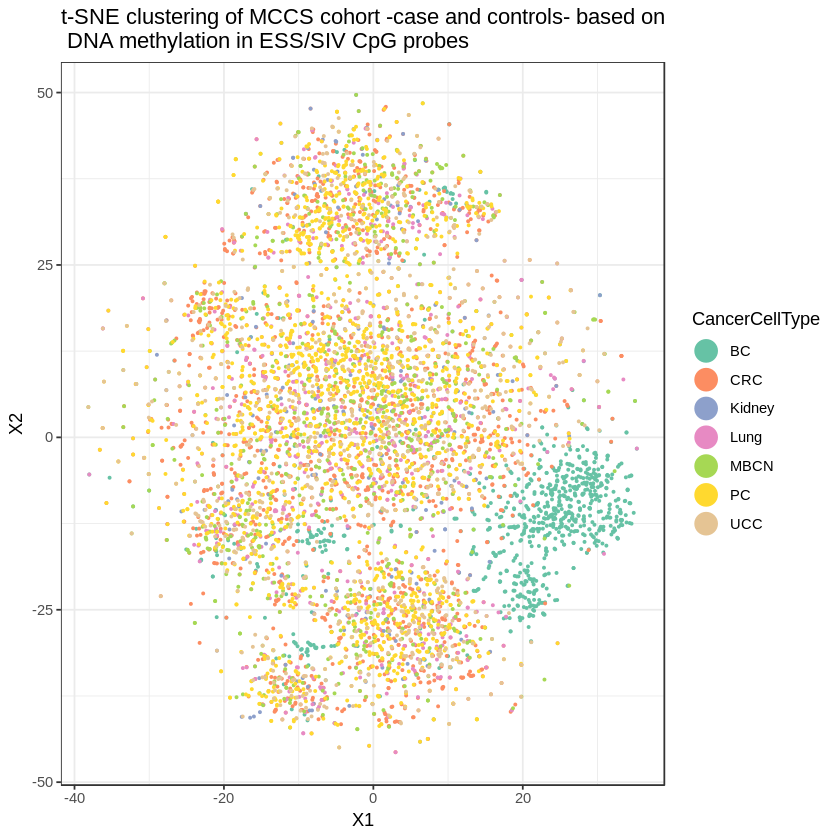

In [10]:

tsne_model_1 = Rtsne(as.matrix(cancer_cases_methy_ESS_SIV_cg), check_duplicates=T, pca=T, perplexity=20, theta=0.5, dims=2)
d_tsne_1 = as.data.frame(tsne_model_1$Y)
d_tsne_1$CancerCellType <- cancer_cases_methy_ESS_SIV$CancerCellType

ggplot(d_tsne_1, aes(x=V1, y=V2,colour = CancerCellType)) +
  geom_point(size=0.45) +
  guides(colour=guide_legend(override.aes=list(size=6))) +
  xlab("X1") + ylab("X2") +theme_bw()+
  ggtitle("t-SNE clustering of MCCS cohort -case and controls- based on \n DNA methylation in ESS/SIV CpG probes") +
  scale_colour_brewer(palette = "Set2")


The ESS_SIV clusters contain multiple CpG probs. The DNA methylation data as averaged accros each cluster.To see if this dataset has the same signal. The tSNE was done the same way on this dataset.

In [11]:
mccs_ess_avg <- read.csv("/data/gunaseka/ESS_MCCS_Analysis/averaged_accros_cluster.csv")

In [12]:
head(mccs_ess_avg)

Sample,CancerCellType,CaseControl,ID,AlcoholAmount,Smoking,bcell,bmi_rrto,cd4t,cd8t,⋯,VIPR2,VTRNA2.1,WDR27,WDR90,ZFP57,ZFYVE28,ZNF251,ZNF681,ZNF714,ZNF890P
Sample_1,BC,0,BC_Pair_1,4,0,0.08745385,29.20516,0.10727967,0.14815719,⋯,1.90055724,-0.172131130,-0.98136321,-0.37835463,0.4677048,3.418657,2.2788181,-4.111436,-2.37729239,-0.6662078
Sample_2,BC,1,BC_Pair_1,2,0,0.10287884,27.96231,0.13150276,0.12602529,⋯,1.99247432,-0.377134561,3.99502545,-2.13995498,2.4609309,2.243908,0.5364608,-4.387155,0.34371430,-0.1857028
Sample_3,BC,1,BC_Pair_2,2,-1,0.09067746,21.87242,0.04251249,0.17096309,⋯,1.39138196,0.150830974,-0.08597206,0.05488047,0.7671964,4.169128,1.8769565,-4.050547,-0.25642456,-1.1704468
Sample_4,BC,0,BC_Pair_2,2,-1,0.10010919,23.83473,0.08627580,0.13397215,⋯,2.05991049,-0.039849101,0.24012048,-1.09355985,3.1355813,3.565403,0.4075999,-4.249466,0.08080532,0.2184171
Sample_5,BC,0,BC_Pair_3,2,-1,0.08467049,23.55767,0.03608380,0.09226610,⋯,0.05257601,-0.052262948,0.58533440,-0.92471476,-0.3802198,2.828289,0.6752125,-4.515023,0.32588108,-1.0060959
Sample_6,BC,1,BC_Pair_3,2,0,0.05459091,34.10303,0.05873613,0.06257519,⋯,1.51852631,0.007166724,-0.05079584,-1.68766306,0.2811630,2.977444,1.5702150,-4.114159,-3.24256129,-1.6433150


In [13]:
data_mccs_ess_avg <-subset(mccs_ess_avg,select = -c(Sample,CancerCellType,CaseControl,ID,AlcoholAmount,Smoking,bcell,bmi_rrto,cd4t,cd8t,gran,mono,nk))

In [14]:
head(data_mccs_ess_avg)

ACADM,ADGRD1,AGPAT4,ANKDD1B,ANKRD20A11P,ANKRD30B,ATP11A,C17orf98,C1orf86,C22orf34,⋯,VIPR2,VTRNA2.1,WDR27,WDR90,ZFP57,ZFYVE28,ZNF251,ZNF681,ZNF714,ZNF890P
-0.7015962,1.303992,4.0285859,0.009686569,-0.68978079,-0.8138972,-0.8130793,0.6439624,-1.5734017,0.21528258,⋯,1.90055724,-0.172131130,-0.98136321,-0.37835463,0.4677048,3.418657,2.2788181,-4.111436,-2.37729239,-0.6662078
-1.5742368,1.897934,5.4150429,0.425302932,-0.37398061,-2.2185285,-0.8060041,0.2699102,-1.1954092,0.54809465,⋯,1.99247432,-0.377134561,3.99502545,-2.13995498,2.4609309,2.243908,0.5364608,-4.387155,0.34371430,-0.1857028
-0.5006276,1.632135,0.8290209,0.653712273,-0.06624538,-0.9158305,0.4992603,1.7063610,-0.4513314,1.00085304,⋯,1.39138196,0.150830974,-0.08597206,0.05488047,0.7671964,4.169128,1.8769565,-4.050547,-0.25642456,-1.1704468
0.6202377,2.377178,4.3738864,0.269818539,0.35549330,-1.4121966,0.2559579,1.0542470,-1.1702811,2.85620427,⋯,2.05991049,-0.039849101,0.24012048,-1.09355985,3.1355813,3.565403,0.4075999,-4.249466,0.08080532,0.2184171
-0.8404002,3.138574,4.9940198,0.868241469,-1.31002241,-0.7276339,-1.1927664,0.4381603,-1.7278624,2.82841966,⋯,0.05257601,-0.052262948,0.58533440,-0.92471476,-0.3802198,2.828289,0.6752125,-4.515023,0.32588108,-1.0060959
-0.6943310,3.694683,0.8220768,-0.249635507,-1.06688765,-2.4352753,-0.2803052,0.3651501,-1.7021914,-0.06967963,⋯,1.51852631,0.007166724,-0.05079584,-1.68766306,0.2811630,2.977444,1.5702150,-4.114159,-3.24256129,-1.6433150


[1] 6926 2210

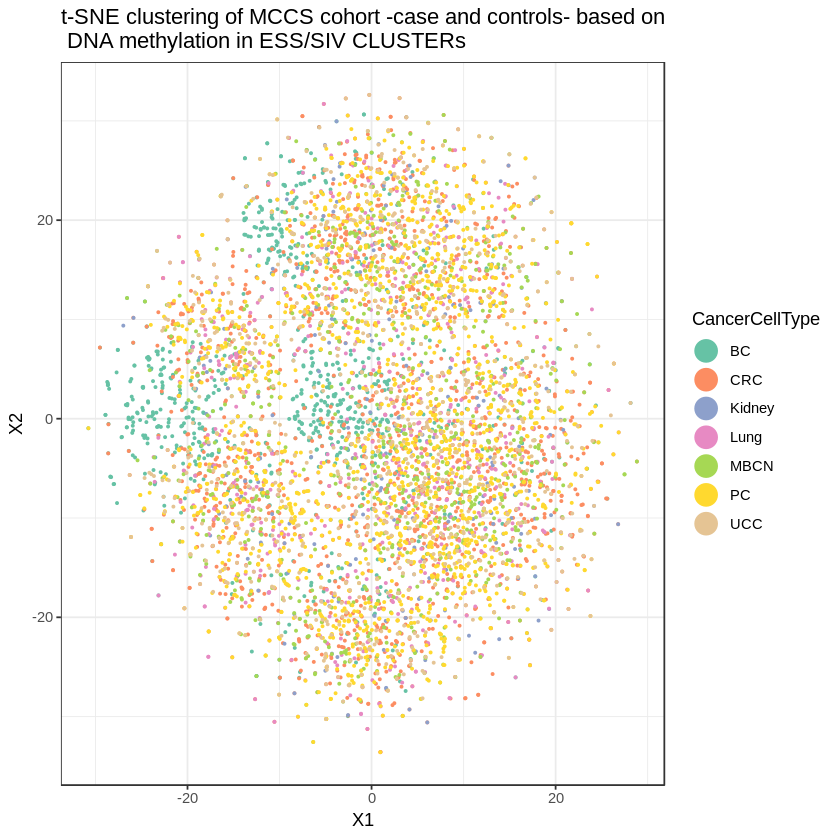

In [16]:
tsne_model_2 = Rtsne(as.matrix(data_mccs_ess_avg), check_duplicates=T, pca=T, perplexity=30, theta=0.5, dims=2)
d_tsne_2 = as.data.frame(tsne_model_2$Y)
d_tsne_2$CancerCellType <- mccs_ess_avg$CancerCellType
nums <- unlist(lapply(cancer_cases_methy_ESS_SIV_cg, is.numeric))
cancer_cases_methy_ESS_SIV_cg <- cancer_cases_methy_ESS_SIV_cg[,nums]
dim(cancer_cases_methy_ESS_SIV)
ggplot(d_tsne_2, aes(x=V1, y=V2,colour = CancerCellType)) +
  geom_point(size=0.45) +
  guides(colour=guide_legend(override.aes=list(size=6))) +
  xlab("X1") + ylab("X2") +theme_bw()+
  ggtitle("t-SNE clustering of MCCS cohort -case and controls- based on \n DNA methylation in ESS/SIV CLUSTERs") +
  scale_colour_brewer(palette = "Set2")

In [14]:
test_VT_DUSP <- mccs_ess_avg[c("DUSP22","CancerCellType","VTRNA2.1")]

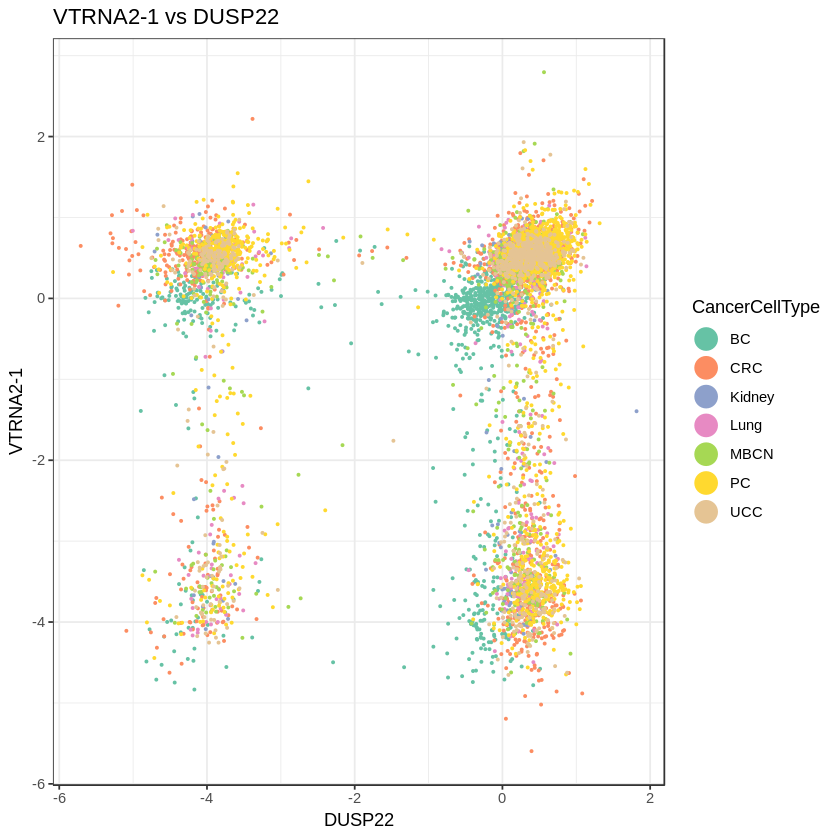

In [19]:
test_VT_DUSP <- mccs_ess_avg[c("DUSP22","CancerCellType","VTRNA2.1")]

ggplot(test_VT_DUSP, aes(x=DUSP22, y=VTRNA2.1,colour = CancerCellType)) +
  geom_point(size=0.45) +
  guides(colour=guide_legend(override.aes=list(size=6))) +
  xlab("DUSP22") + ylab("VTRNA2-1") +theme_bw()+
  ggtitle("VTRNA2-1 vs DUSP22") +
  scale_colour_brewer(palette = "Set2")

# 2.  Clustering Cancer Cases
## 1. Prostate Cancer cases

[1]  863 2210

[1]  863 1798

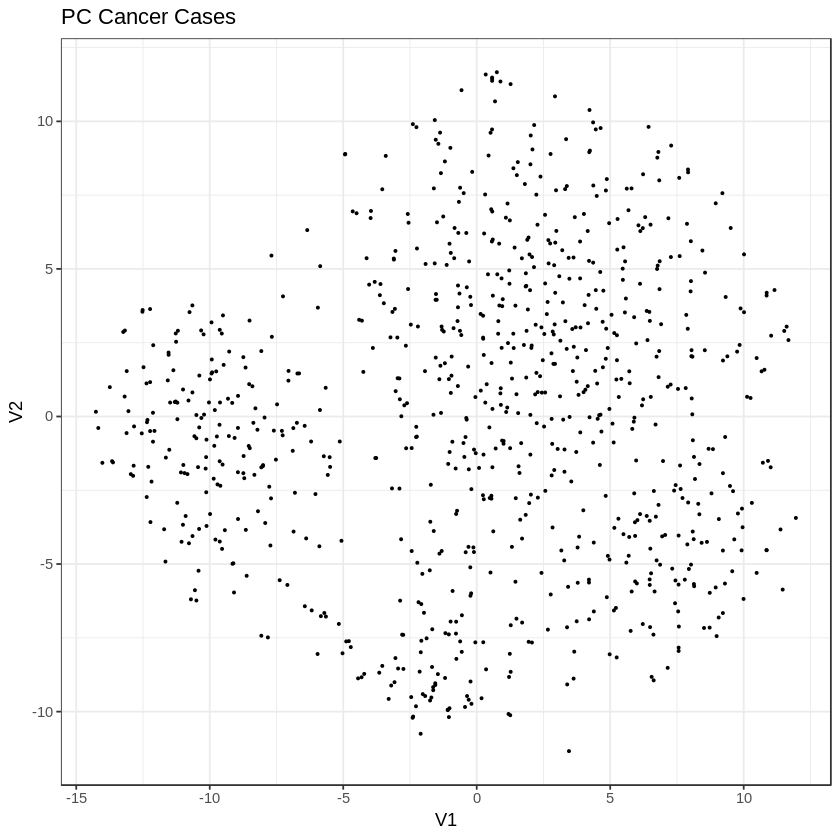

DBSCAN clustering for 863 objects.
Parameters: eps = 1.3, minPts = 15
The clustering contains 5 cluster(s) and 265 noise points.

  0   1   2   3   4   5 
265 297  86 142  62  11 

Available fields: cluster, eps, minPts

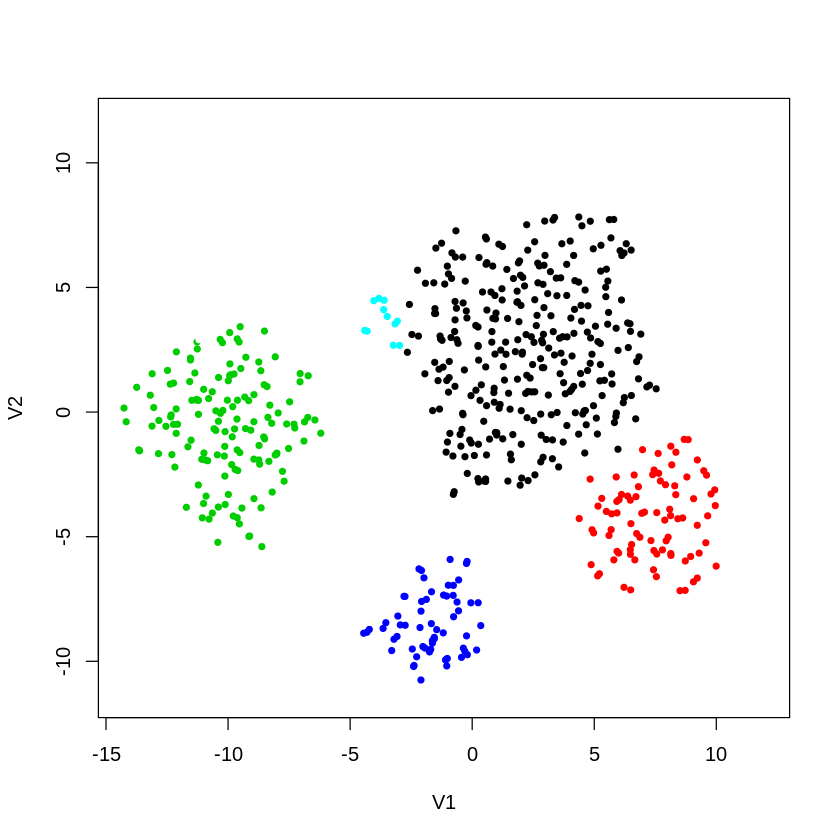

In [55]:
cancer_cases <- mccs_ess[mccs_ess$CancerCellType=='PC' & mccs_ess$CaseControl==1,]
cancer_cases_methy<- cancer_cases[,ess_siv_probs$CG]

dim(cancer_cases_methy)
nums <- unlist(lapply(cancer_cases_methy, is.numeric))
cancer_cases_methy <- cancer_cases_methy[,nums]
cancer_cases_methy <- cancer_cases_methy[ , colSums(is.na(cancer_cases_methy)) == 0]
dim(cancer_cases_methy)

set.seed(9)
tsne_model_3 = Rtsne(as.matrix(cancer_cases_methy), check_duplicates=T, pca=T, perplexity=30, theta=0.5, dims=2)
d_tsne_3 = as.data.frame(tsne_model_3$Y)

ggplot(d_tsne_3, aes(x=V1, y=V2)) +
  geom_point(size=0.45) +
  guides(colour=guide_legend(override.aes=list(size=6))) +
  xlab("V1") + ylab("V2") +theme_bw()+
  ggtitle("PC Cancer Cases") +
  scale_colour_brewer(palette = "Set2")

res <- dbscan::dbscan(d_tsne_3,eps = 1.3, minPts = 15)
plot(d_tsne_3, col=res$cluster, pch = 20)
#points(d_tsne_1[res$cluster == 0L], col = "grey", pch = "+")
res

## 2. Breast Cancer Cases

[1]  433 2210

[1]  433 1607

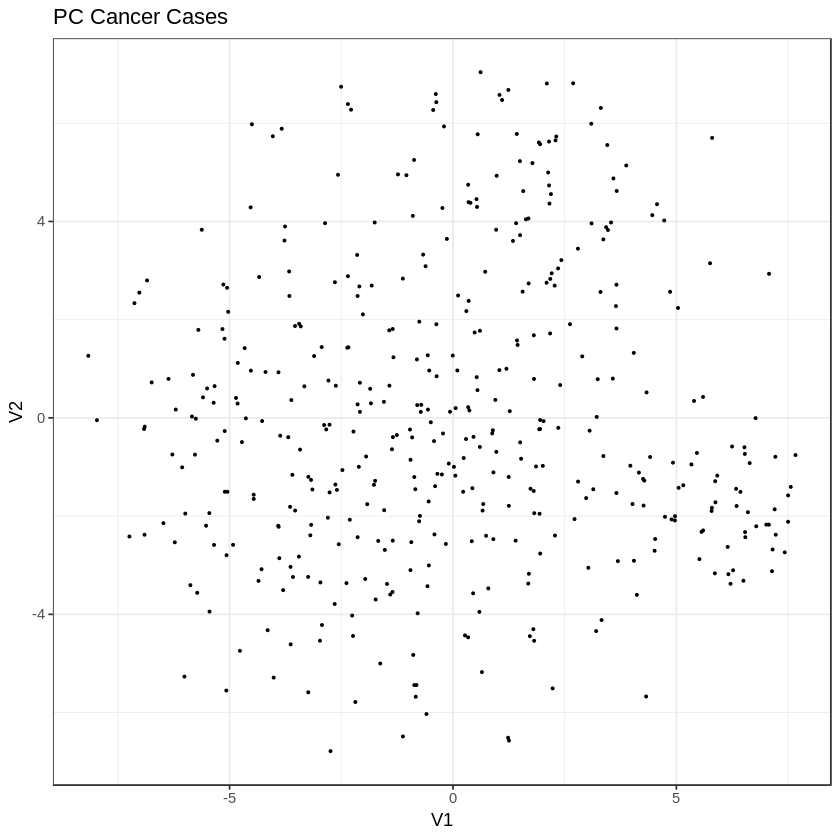

DBSCAN clustering for 433 objects.
Parameters: eps = 1.2, minPts = 15
The clustering contains 3 cluster(s) and 96 noise points.

  0   1   2   3 
 96 222  61  54 

Available fields: cluster, eps, minPts

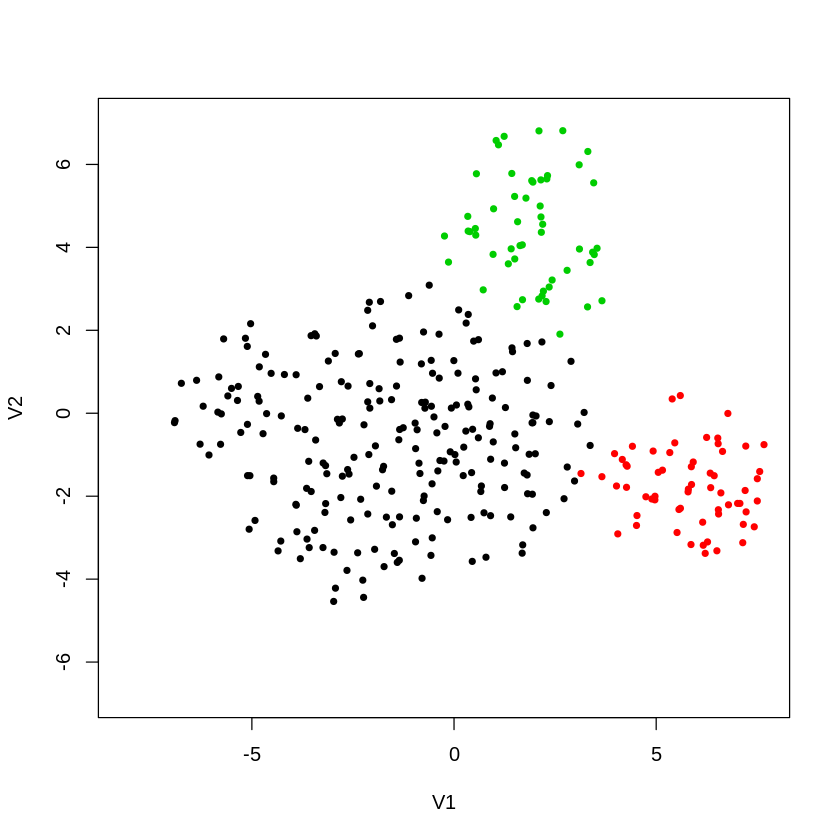

In [57]:
cancer_cases <- mccs_ess[mccs_ess$CancerCellType=='BC' & mccs_ess$CaseControl==1,]
cancer_cases_methy<- cancer_cases[,ess_siv_probs$CG]

dim(cancer_cases_methy)
nums <- unlist(lapply(cancer_cases_methy, is.numeric))
cancer_cases_methy <- cancer_cases_methy[,nums]
cancer_cases_methy <- cancer_cases_methy[ , colSums(is.na(cancer_cases_methy)) == 0]
dim(cancer_cases_methy)

set.seed(9)
tsne_model_3 = Rtsne(as.matrix(cancer_cases_methy), check_duplicates=T, pca=T, perplexity=30, theta=0.5, dims=2)
d_tsne_3 = as.data.frame(tsne_model_3$Y)

ggplot(d_tsne_3, aes(x=V1, y=V2)) +
  geom_point(size=0.45) +
  guides(colour=guide_legend(override.aes=list(size=6))) +
  xlab("V1") + ylab("V2") +theme_bw()+
  ggtitle("BC Cancer Cases") +
  scale_colour_brewer(palette = "Set2")

res <- dbscan::dbscan(d_tsne_3,eps = 1.2, minPts = 15)
plot(d_tsne_3, col=res$cluster, pch = 20)
#points(d_tsne_1[res$cluster == 0L], col = "grey", pch = "+")
res

[1]  834 2210

[1]  834 1683

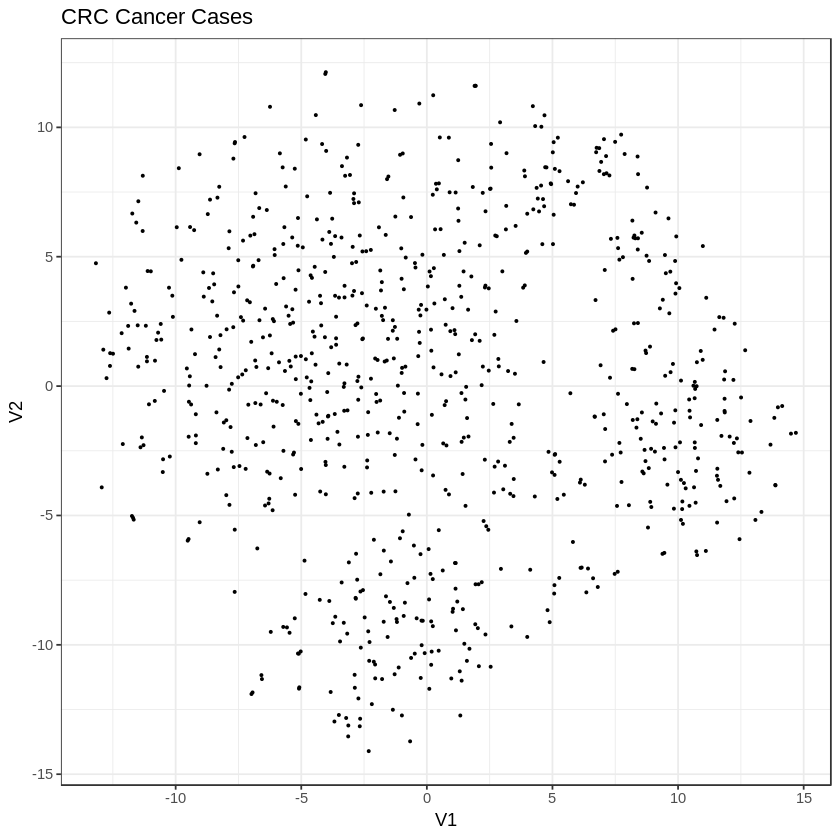

DBSCAN clustering for 834 objects.
Parameters: eps = 1.3, minPts = 15
The clustering contains 5 cluster(s) and 390 noise points.

  0   1   2   3   4   5 
390 235  44  59  84  22 

Available fields: cluster, eps, minPts

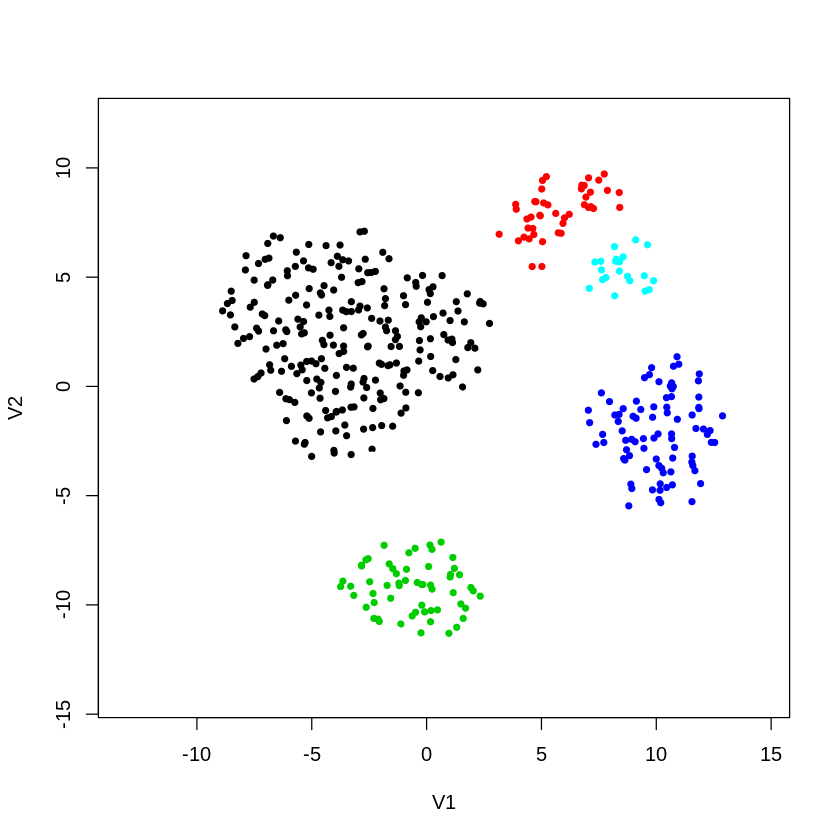

In [59]:
cancer_cases <- mccs_ess[mccs_ess$CancerCellType=='CRC' & mccs_ess$CaseControl==1,]
cancer_cases_methy<- cancer_cases[,ess_siv_probs$CG]

dim(cancer_cases_methy)
nums <- unlist(lapply(cancer_cases_methy, is.numeric))
cancer_cases_methy <- cancer_cases_methy[,nums]
cancer_cases_methy <- cancer_cases_methy[ , colSums(is.na(cancer_cases_methy)) == 0]
dim(cancer_cases_methy)

set.seed(9)
tsne_model_3 = Rtsne(as.matrix(cancer_cases_methy), check_duplicates=T, pca=T, perplexity=30, theta=0.5, dims=2)
d_tsne_3 = as.data.frame(tsne_model_3$Y)

ggplot(d_tsne_3, aes(x=V1, y=V2)) +
  geom_point(size=0.45) +
  guides(colour=guide_legend(override.aes=list(size=6))) +
  xlab("V1") + ylab("V2") +theme_bw()+
  ggtitle("CRC Cancer Cases") +
  scale_colour_brewer(palette = "Set2")

res <- dbscan::dbscan(d_tsne_3,eps = 1.3, minPts = 15)
plot(d_tsne_3, col=res$cluster, pch = 20)
#points(d_tsne_1[res$cluster == 0L], col = "grey", pch = "+")
res

[1]  331 2210

[1]  331 1955

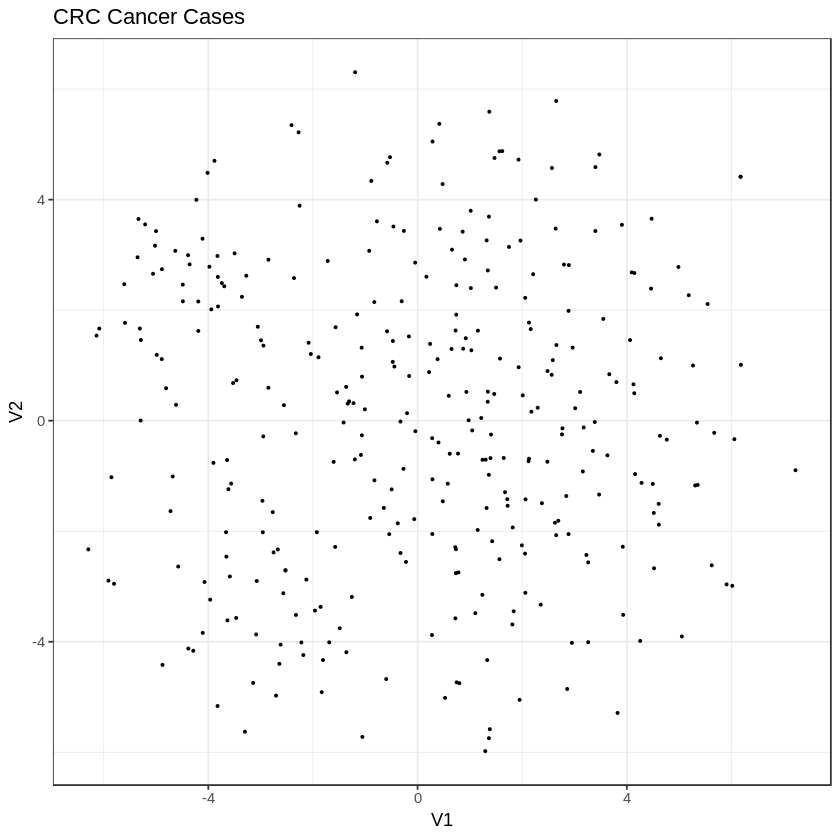

DBSCAN clustering for 331 objects.
Parameters: eps = 1.1, minPts = 15
The clustering contains 3 cluster(s) and 106 noise points.

  0   1   2   3 
106 153  36  36 

Available fields: cluster, eps, minPts

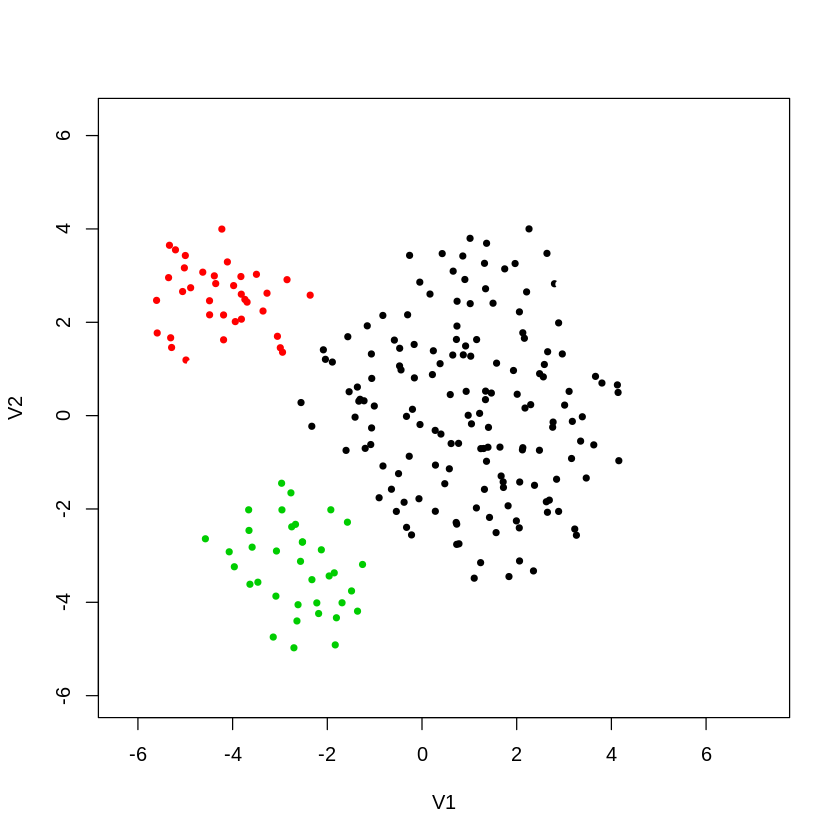

In [64]:
cancer_cases <- mccs_ess[mccs_ess$CancerCellType=='Lung' & mccs_ess$CaseControl==1,]
cancer_cases_methy<- cancer_cases[,ess_siv_probs$CG]

dim(cancer_cases_methy)
nums <- unlist(lapply(cancer_cases_methy, is.numeric))
cancer_cases_methy <- cancer_cases_methy[,nums]
cancer_cases_methy <- cancer_cases_methy[ , colSums(is.na(cancer_cases_methy)) == 0]
dim(cancer_cases_methy)

set.seed(9)
tsne_model_3 = Rtsne(as.matrix(cancer_cases_methy), check_duplicates=T, pca=T, perplexity=30, theta=0.5, dims=2)
d_tsne_3 = as.data.frame(tsne_model_3$Y)

ggplot(d_tsne_3, aes(x=V1, y=V2)) +
  geom_point(size=0.45) +
  guides(colour=guide_legend(override.aes=list(size=6))) +
  xlab("V1") + ylab("V2") +theme_bw()+
  ggtitle("Lung Cancer Cases") +
  scale_colour_brewer(palette = "Set2")

res <- dbscan::dbscan(d_tsne_3,eps = 1.1, minPts = 15)
plot(d_tsne_3, col=res$cluster, pch = 20)
#points(d_tsne_1[res$cluster == 0L], col = "grey", pch = "+")
res

[1]  435 2210

[1]  435 1871

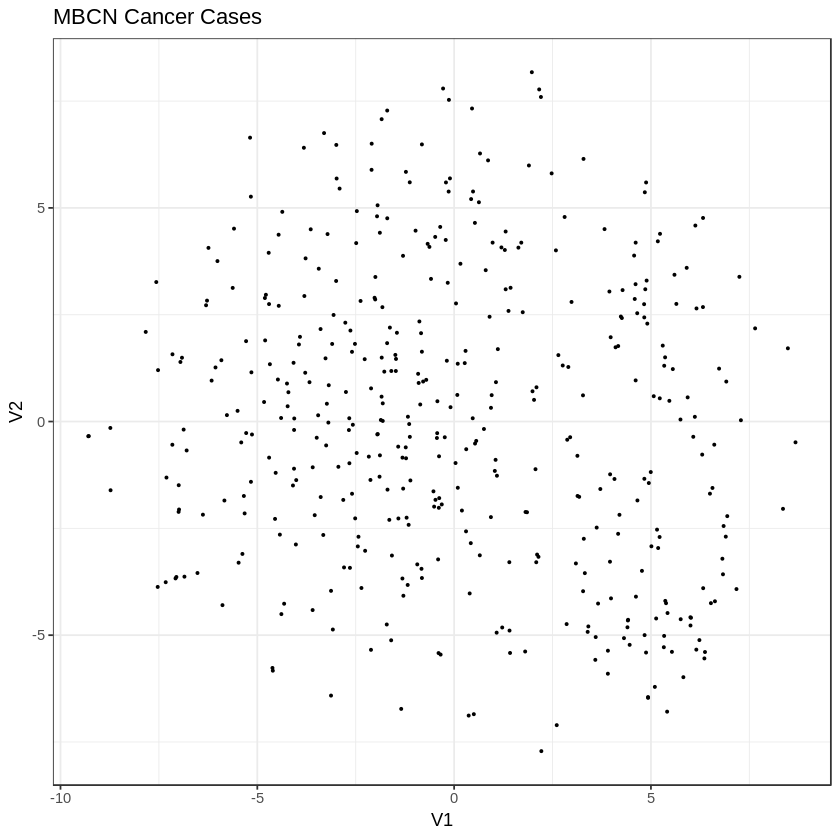

DBSCAN clustering for 435 objects.
Parameters: eps = 1.1, minPts = 15
The clustering contains 3 cluster(s) and 231 noise points.

  0   1   2   3 
231 136  44  24 

Available fields: cluster, eps, minPts

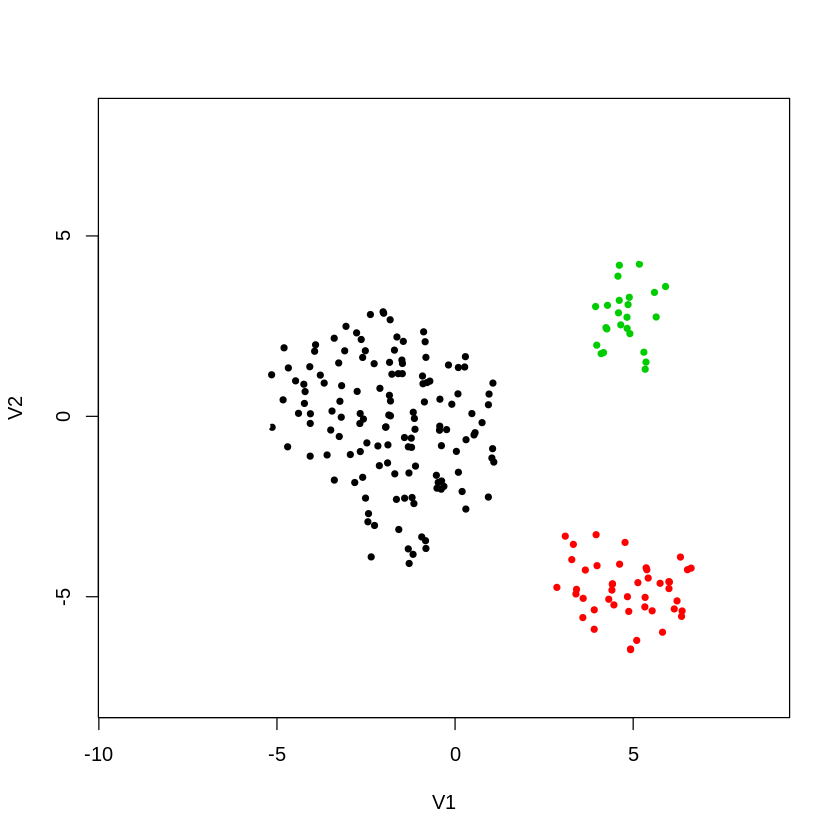

In [66]:
cancer_cases <- mccs_ess[mccs_ess$CancerCellType=='MBCN' & mccs_ess$CaseControl==1,]
cancer_cases_methy<- cancer_cases[,ess_siv_probs$CG]

dim(cancer_cases_methy)
nums <- unlist(lapply(cancer_cases_methy, is.numeric))
cancer_cases_methy <- cancer_cases_methy[,nums]
cancer_cases_methy <- cancer_cases_methy[ , colSums(is.na(cancer_cases_methy)) == 0]
dim(cancer_cases_methy)

set.seed(9)
tsne_model_3 = Rtsne(as.matrix(cancer_cases_methy), check_duplicates=T, pca=T, perplexity=30, theta=0.5, dims=2)
d_tsne_3 = as.data.frame(tsne_model_3$Y)

ggplot(d_tsne_3, aes(x=V1, y=V2)) +
  geom_point(size=0.45) +
  guides(colour=guide_legend(override.aes=list(size=6))) +
  xlab("V1") + ylab("V2") +theme_bw()+
  ggtitle("MBCN Cancer Cases") +
  scale_colour_brewer(palette = "Set2")

res <- dbscan::dbscan(d_tsne_3,eps = 1.1, minPts = 15)
plot(d_tsne_3, col=res$cluster, pch = 20)
#points(d_tsne_1[res$cluster == 0L], col = "grey", pch = "+")
res

[1]  426 2210

[1]  426 1961

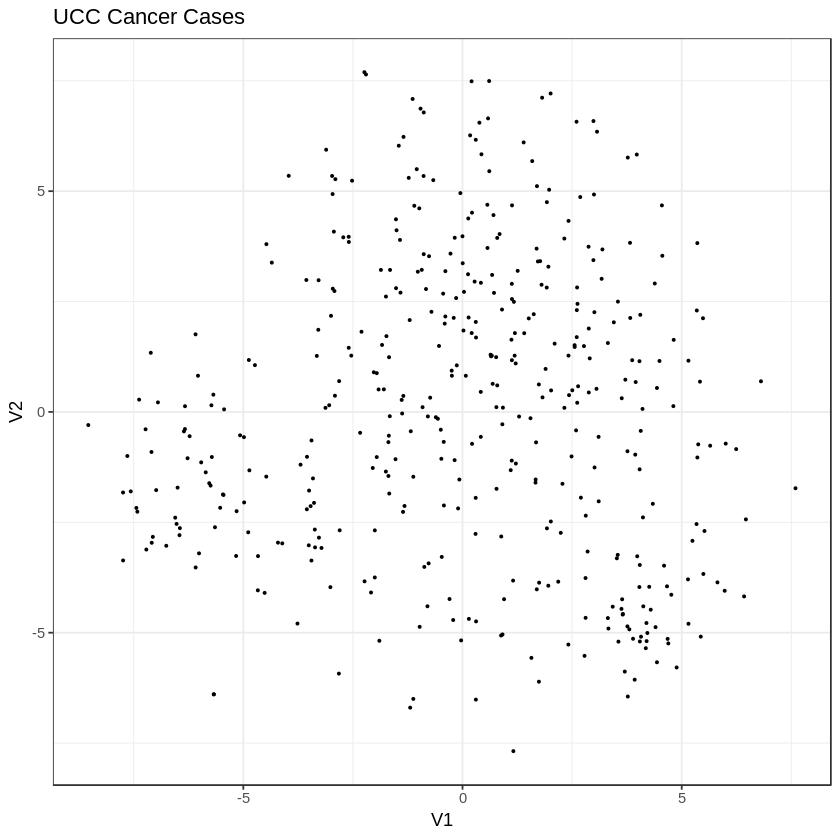

DBSCAN clustering for 426 objects.
Parameters: eps = 1.1, minPts = 15
The clustering contains 3 cluster(s) and 170 noise points.

  0   1   2   3 
170 173  37  46 

Available fields: cluster, eps, minPts

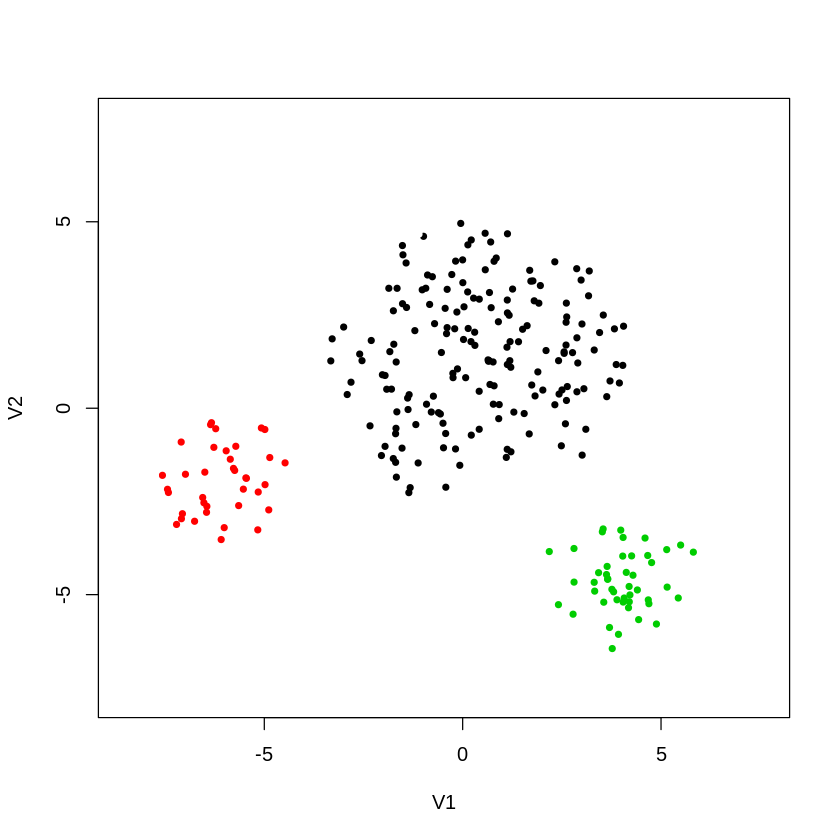

In [68]:
cancer_cases <- mccs_ess[mccs_ess$CancerCellType=='UCC' & mccs_ess$CaseControl==1,]
cancer_cases_methy<- cancer_cases[,ess_siv_probs$CG]

dim(cancer_cases_methy)
nums <- unlist(lapply(cancer_cases_methy, is.numeric))
cancer_cases_methy <- cancer_cases_methy[,nums]
cancer_cases_methy <- cancer_cases_methy[ , colSums(is.na(cancer_cases_methy)) == 0]
dim(cancer_cases_methy)

set.seed(9)
tsne_model_3 = Rtsne(as.matrix(cancer_cases_methy), check_duplicates=T, pca=T, perplexity=30, theta=0.5, dims=2)
d_tsne_3 = as.data.frame(tsne_model_3$Y)

ggplot(d_tsne_3, aes(x=V1, y=V2)) +
  geom_point(size=0.45) +
  guides(colour=guide_legend(override.aes=list(size=6))) +
  xlab("V1") + ylab("V2") +theme_bw()+
  ggtitle("UCC Cancer Cases") +
  scale_colour_brewer(palette = "Set2")

res <- dbscan::dbscan(d_tsne_3,eps = 1.1, minPts = 15)
plot(d_tsne_3, col=res$cluster, pch = 20)
#points(d_tsne_1[res$cluster == 0L], col = "grey", pch = "+")
res